In [207]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [208]:
import numpy as np
import pandas as pd
import obspy
from obspy import UTCDateTime
import obspy.signal.filter
import sys           
sys.path.append("/data/wsd01/pnwstore/")
from pnwstore.mseed import WaveformClient
client = WaveformClient()
import datetime
import scipy
import math
import glob
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import warnings
warnings.filterwarnings("ignore")

In [132]:
# read txt-file with UTC times and type of activity
df_activity = pd.read_csv('../../MtStHelens_activity/mt_st_helens_activity.txt', header=1, skiprows=11)
df_activity.set_index('UTC',inplace=True)
df_activity.index = pd.to_datetime(df_activity.index).tz_localize(None)
df_activity

activity
UTC                         
2004-09-23 09:00:00        s
2004-09-25 19:00:00        q
2004-09-26 00:00:00        c
2004-09-29 00:00:00        q
2004-10-01 19:02:00        a
2004-10-02 19:14:00        a
2004-10-02 19:14:00        t
2004-10-03 09:50:00        t
2004-10-03 11:30:00       et
2004-10-03 17:40:00        a
2004-10-04 16:47:00        a
2004-10-04 19:12:00        a
2004-10-05 00:40:00        a
2004-10-05 16:05:00        a
2004-10-11 00:00:00        l
2004-10-11 00:00:00        d
2004-10-15 00:00:00       ed
2004-10-15 00:00:00        d
2004-10-24 00:00:00       ed
2004-10-25 00:00:00        d
2004-12-18 00:00:00       ed
2005-01-03 00:00:00        d
2005-03-09 00:00:00       ed
2005-03-09 00:30:00        a
2005-03-19 00:00:00        d
2005-07-02 00:00:00        r
2005-07-18 00:00:00       ed
2005-07-19 00:00:00        r
2005-07-31 00:00:00       er
2005-08-06 00:00:00        d
2005-10-09 00:00:00       ed
2005-10-09 00:00:00        d
2006-04-01 00:00:00       ed
2006-12-19 00:00:00        a
2008-01-16 00:00:00        a
2008-01-16 00:00:00        q
2008-01-16 00:00:00        t
2008-07-10 00:00:00       ee

# All Stations

In [96]:
def zsc(s):
    # log transform data
    log_s = np.log10(s).replace([np.inf, -np.inf], np.nan).dropna()
    
    # compute mean/std/min
    mn = np.mean(log_s)
    std = np.std(log_s)
    minzsc = np.min(log_s)                                                    

    # Calculate percentile
    s=(np.log10(s)-mn)/std
    s=s.fillna(minzsc)
    s=10**s
    return s

def zsc2(s):
    s=zsc(s)
    s=s.rolling(window=2).min()
    s[0]=s[1]
    return s

In [97]:
def norm(s):
    diff_s = max(s)-min(s)
    s_norm = ((s - min(s))/diff_s)
    return s_norm

In [98]:
def mask_df(row):
    peaks, properties = scipy.signal.find_peaks(row, prominence=(row.rolling('10D').median()*100).to_numpy(), distance=len(row))
    row_masked = row.copy()
    try:
#         row_masked[row_masked>min(row_masked.iloc[properties['left_bases'][0]:properties['right_bases'][0]])]=np.nan
        row_masked.iloc[properties['left_bases'][0]-500:properties['right_bases'][0]+500]=np.nan
    except:
        pass
    return row_masked

In [360]:
df = pd.read_csv('../{}_{}_extended2.csv'.format(2005,'CDF'))
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df = df.resample('10min').median()
df

rsam         mf         hf      dsar     ldsar  \
time                                                                       
2005-01-01 00:10:00   4.945239   3.327040   3.023724  2.135254  3.193794   
2005-01-01 00:20:00  14.299374   9.437932   9.020937  2.067824  3.322315   
2005-01-01 00:30:00  19.506793  14.026343  13.941646  1.997801  3.013333   
2005-01-01 00:40:00  21.419407  15.588493  16.827896  1.909743  2.962972   
2005-01-01 00:50:00  36.813609  22.533717  18.656808  2.503708  3.526702   
...                        ...        ...        ...       ...       ...   
2005-12-31 23:10:00  23.559298  16.286082  22.342232  1.575470  3.128742   
2005-12-31 23:20:00  32.445791  21.110918  29.769957  1.531733  3.453893   
2005-12-31 23:30:00  25.365453  17.038176  24.951289  1.484996  3.255849   
2005-12-31 23:40:00  41.677959  24.266787  35.080026  1.527911  3.723926   
2005-12-31 23:50:00  14.242326  12.349440  23.203378  1.152814  2.393138   

                         vsar           rms          rmes           pgv  \
time                                                                      
2005-01-01 00:10:00  1.100312  7.339902e-08  3.800189e-08  4.671225e-07   
2005-01-01 00:20:00  1.046225  1.718446e-07  1.039872e-07  8.619484e-07   
2005-01-01 00:30:00  1.006075  2.533477e-07  1.711954e-07  1.560126e-06   
2005-01-01 00:40:00  0.926348  2.580203e-07  1.780204e-07  1.022303e-06   
2005-01-01 00:50:00  1.207801  3.446835e-07  1.880605e-07  3.577452e-06   
...                       ...           ...           ...           ...   
2005-12-31 23:10:00  0.728937  4.068775e-07  2.690498e-07  2.633188e-06   
2005-12-31 23:20:00  0.709135  5.283749e-07  3.299031e-07  2.888631e-06   
2005-12-31 23:30:00  0.682858  6.390464e-07  3.869980e-07  3.784052e-06   
2005-12-31 23:40:00  0.691755  8.009806e-07  4.541398e-07  5.257351e-06   
2005-12-31 23:50:00  0.532226  7.642242e-07  4.195382e-07  3.923763e-06   

                          pga  zsc2_rsam   zsc2_mf   zsc2_hf  zsc2_dsar  \
time                                                                      
2005-01-01 00:10:00  0.000060   0.085480  0.071757  0.056090   1.544017   
2005-01-01 00:20:00  0.000144   0.085480  0.071757  0.056090   1.544017   
2005-01-01 00:30:00  0.000187   0.475663  0.427651  0.362539   1.230196   
2005-01-01 00:40:00  0.000098   0.785817  0.842695  0.762326   0.913800   
2005-01-01 00:50:00  0.000126   0.914088  1.009676  1.051125   0.913800   
...                       ...        ...       ...       ...        ...   
2005-12-31 23:10:00  0.000399   0.920703  1.042404  1.385142   0.256859   
2005-12-31 23:20:00  0.000526   1.066203  1.088257  1.705365   0.213330   
2005-12-31 23:30:00  0.000692   1.201431  1.175704  2.059257   0.173897   
2005-12-31 23:40:00  0.000835   1.201431  1.175704  2.059257   0.173897   
2005-12-31 23:50:00  0.000694   0.472600  0.677643  1.819111   0.032734   

                     zsc2_ldsar  zsc2_vsar  zsc2_rms  zsc2_rmes  zsc2_pgv  \
time                                                                        
2005-01-01 00:10:00    1.361495   1.820252  0.054439   0.019206  0.076326   
2005-01-01 00:20:00    1.361495   1.820252  0.054439   0.019206  0.076326   
2005-01-01 00:30:00    0.901336   1.433441  0.191143   0.159897  0.168048   
2005-01-01 00:40:00    0.799799   0.865927  0.339042   0.456738  0.209362   
2005-01-01 00:50:00    0.799799   0.865927  0.348315   0.495919  0.209362   
...                         ...        ...       ...        ...       ...   
2005-12-31 23:10:00    0.696348   0.200473  0.556735   0.893667  0.587636   
2005-12-31 23:20:00    1.176625   0.169447  0.682369   1.183114  0.708399   
2005-12-31 23:30:00    1.560563   0.134562  1.003598   1.817440  0.798145   
2005-12-31 23:40:00    1.560563   0.134562  1.328913   2.543348  1.130209   
2005-12-31 23:50:00    0.175865   0.029387  1.730599   3.014562  1.184253   

                     zsc2_pga  
time                           
2005-01-01 00:10:00

In [831]:
year = 2008

In [832]:
all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_{}/*/*.csv'.format(year)))
sta_list = np.unique([file.split('/')[-2] for file in all_files])
for sta in sta_list:
    print(sta)
    sta_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/tmp_{}/{}/*.csv'.format(year,sta)))
    li = []
    for filename in sta_files:
        frame = pd.read_csv(filename)
        li.append(frame)

    df = pd.concat(li, axis=0, ignore_index=True)
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df.sort_index()

    # compute transforms and save
    df['zsc2_rsam'] = zsc2(df['rsam'])
    df['zsc2_mf'] = zsc2(df['mf'])
    df['zsc2_hf'] = zsc2(df['hf'])
    df['zsc2_dsar'] = zsc2(df['dsar'])
    df['zsc2_ldsar'] = zsc2(df['ldsar'])
    df['zsc2_vsar'] = zsc2(df['vsar'])
    df['zsc2_rms'] = zsc2(df['rms'])
    df['zsc2_rmes'] = zsc2(df['rmes'])
    df['zsc2_pgv'] = zsc2(df['pgv'])
    df['zsc2_pga'] = zsc2(df['pga'])

    df.to_csv('../data/{}_{}_extended2.csv'.format(year,sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')

CDF
EDM
ELK
FL2
HSR
JUN
NED
SEP
SHW
SOS
STD
SUG
SWFL
TDL
VALT


In [14]:
sta = 'FL2'
all_files = sorted(glob.glob('../data/*_{}_extended2.csv'.format(sta)))
print(all_files)
li = []
for filename in all_files:
    frame = pd.read_csv(filename)
    li.append(frame)

df = pd.concat(li, axis=0, ignore_index=True)
df.set_index('time',inplace=True)
df.index = pd.to_datetime(df.index).tz_localize(None)
df.sort_index()
df.to_csv('../data/{}_extended2_long2.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')

['../data/2000_FL2_extended2.csv', '../data/2001_FL2_extended2.csv', '../data/2002_FL2_extended2.csv', '../data/2003_FL2_extended2.csv', '../data/2004_FL2_extended2.csv', '../data/2005_FL2_extended2.csv', '../data/2006_FL2_extended2.csv', '../data/2007_FL2_extended2.csv', '../data/2008_FL2_extended2.csv', '../data/2009_FL2_extended2.csv', '../data/2010_FL2_extended2.csv', '../data/2011_FL2_extended2.csv', '../data/2012_FL2_extended2.csv', '../data/2013_FL2_extended2.csv', '../data/2014_FL2_extended2.csv', '../data/2015_FL2_extended2.csv', '../data/2016_FL2_extended2.csv', '../data/2017_FL2_extended2.csv', '../data/2018_FL2_extended2.csv', '../data/2019_FL2_extended2.csv', '../data/2020_FL2_extended2.csv', '../data/2021_FL2_extended2.csv', '../data/2022_FL2_extended2.csv']


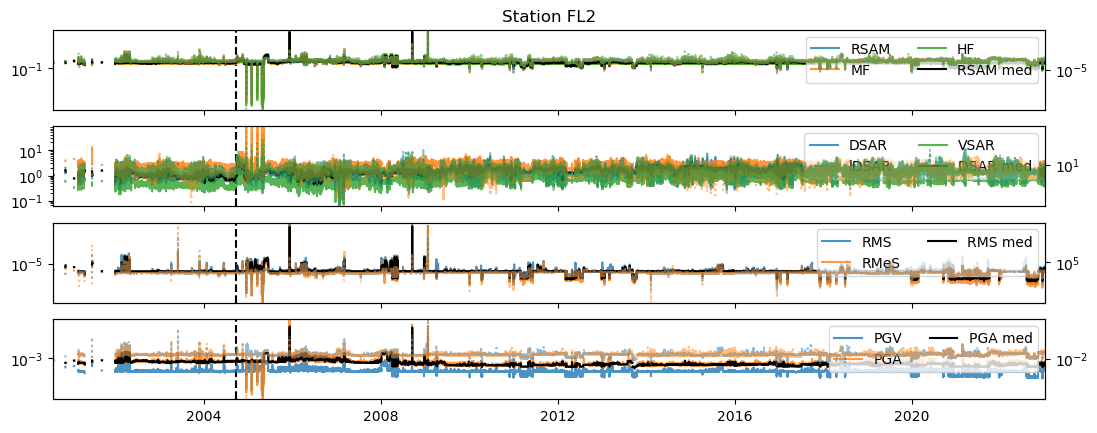

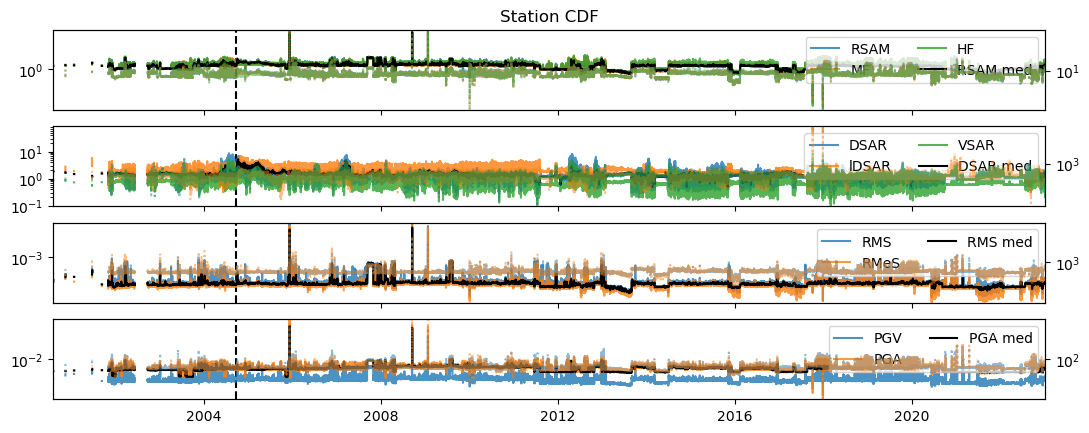

In [15]:
# all_files = sorted(glob.glob('../{}_*_extended2.csv'.format(year)))
# sta_list = np.unique([file.split('/')[1].split('_')[1] for file in all_files])
# year = 2000
sta_list = ['FL2', 'CDF']
for sta in sta_list:
#     df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta))
    df = pd.read_csv('../data/{}_extended2_long2.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.resample('10min').median()
    
#     df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)
        
    df = df.rolling('6H', center=True, closed='both').median()
    df['rsam_median'] = df['rsam'].rolling('2D').median()
    df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
    df['dsar_median'] = df['dsar'].rolling('2D').median()
    df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
    df['rms_median'] = df['rms'].rolling('2D').median()
    df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
    df['pga_median'] = df['pga'].rolling('2D').median()
    df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()
#     df = df.resample('1H').median()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8))

    ax1.plot(df['rsam'], label='RSAM', alpha=0.8)
    ax1.plot(df['mf'], label='MF', alpha=0.8)
    ax1.plot(df['hf'], label='HF', alpha=0.8)
    ax1.plot(df['rsam_median'], label='RSAM med',color='k')
    ax1.set_ylim(min(df['rsam'].min(),df['mf'].min(),df['hf'].min()),max(df['rsam'].max(),df['mf'].max(),df['hf'].max()))

    ax11 = ax1.twinx()
    ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.5)
    ax11.set_ylim(min(df['zsc2_rsam'].min(),df['zsc2_mf'].min(),df['zsc2_hf'].min()),max(df['zsc2_rsam'].max(),df['zsc2_mf'].max(),df['zsc2_hf'].max()))

    ax2.plot(df['dsar'], label='DSAR', alpha=0.8)
    ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8)
    ax2.plot(df['vsar'], label='VSAR', alpha=0.8)
    ax2.plot(df['dsar_median'], label='DSAR med',color='k')
    ax2.set_ylim(min(df['dsar'].min(),df['ldsar'].min(),df['vsar'].min()),max(df['dsar'].max(),df['ldsar'].max(),df['vsar'].max()))

    ax22 = ax2.twinx()
    ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_vsar'], linestyle=':', alpha=0.5)
    ax22.set_ylim(min(df['zsc2_dsar'].min(),df['zsc2_ldsar'].min(),df['zsc2_vsar'].min()),
                  max(df['zsc2_dsar'].max(),df['zsc2_ldsar'].max(),df['zsc2_vsar'].max()))
#     ax2.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
#     ax2.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')

    ax3.plot(df['rms'], label='RMS', alpha=0.8)
    ax3.plot(df['rmes'], label='RMeS', alpha=0.8)
    ax3.plot(df['rms_median'], label='RMS med',color='k')
#     ax3.plot(df['pgv'], label='PGV', alpha=0.8)
#     ax3.plot(df['pga'], label='PGA', alpha=0.8)
#     ax3.set_ylim(0,max(df['rms'].max(),df['rmes'].max(),df['pgv'].max(),df['pga'].max())) # linear
    ax3.set_ylim(min(df['rms'].min(),df['rmes'].min()),max(df['rms'].max(),df['rmes'].max()))


    ax33 = ax3.twinx()
    ax33.plot(df['zsc2_rms'],linestyle=':', alpha=0.5)
    ax33.plot(df['zsc2_rmes'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
#     ax33.set_ylim(0,max(df['zsc2_rms'].max(),df['zsc2_rmes'].max(),df['zsc2_pgv'].max(),df['zsc2_pga'].max())) # linear
    ax33.set_ylim(min(df['zsc2_rms'].min(),df['zsc2_rmes'].min()),max(df['zsc2_rms'].max(),df['zsc2_rmes'].max()))      

    ax4.plot(df['pgv'], label='PGV', alpha=0.8)
    ax4.plot(df['pga'], label='PGA', alpha=0.8)
    ax4.plot(df['pga_median'], label='PGA med',color='k')
    ax4.set_ylim(min(df['pgv'].min(),df['pga'].min()),max(df['pgv'].max(),df['pga'].max())) # linear

    ax44 = ax4.twinx()
    ax44.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
    ax44.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
    ax44.set_ylim(min(df['zsc2_pgv'].min(),df['zsc2_pga'].min()),max(df['zsc2_pgv'].max(),df['zsc2_pga'].max()))
    
    ax1.set_xlim(df.index[0], df.index[-1])
    ax1.vlines(UTCDateTime('2004-09-23T09:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-09-23T09:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-09-23T09:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')
    
#     ax1.vlines(UTCDateTime('2004-10-01T19:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
#     ax2.vlines(UTCDateTime('2004-10-01T19:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
#     ax3.vlines(UTCDateTime('2004-10-01T19:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
#     ax4.vlines(UTCDateTime('2004-10-01T19:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')

    ax1.set_title('Station {}'.format(sta))
    ax1.legend(ncol=2, loc='upper right')
    ax2.legend(ncol=2, loc='upper right')
    ax3.legend(ncol=2, loc='upper right')
    ax4.legend(ncol=2, loc='upper right')
    
    ax1.set_yscale('log');ax11.set_yscale('log')
    ax2.set_yscale('log');ax22.set_yscale('log')
    ax3.set_yscale('log');ax33.set_yscale('log')
    ax4.set_yscale('log');ax44.set_yscale('log')

    
#     file_path = '../plots/{}/'.format(year)
    file_path = '../plots/'
    if not os.path.exists(file_path): # create path if not exist
        os.makedirs(file_path)
#     plt.savefig(file_path+'{}_{}_log_long.png'.format(year,year,sta), dpi=300, bbox_inches='tight')
    plt.savefig(file_path+'{}_log_long.png'.format(sta), dpi=300, bbox_inches='tight')
    fig.show()

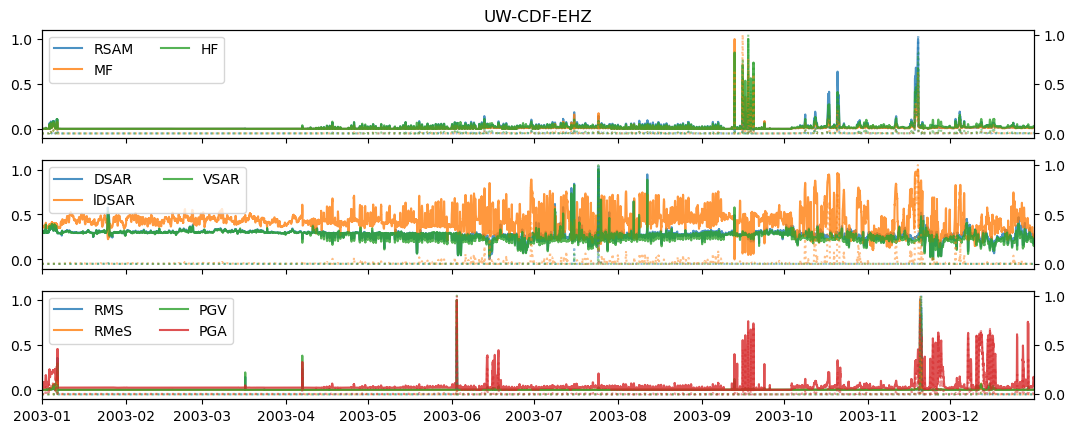

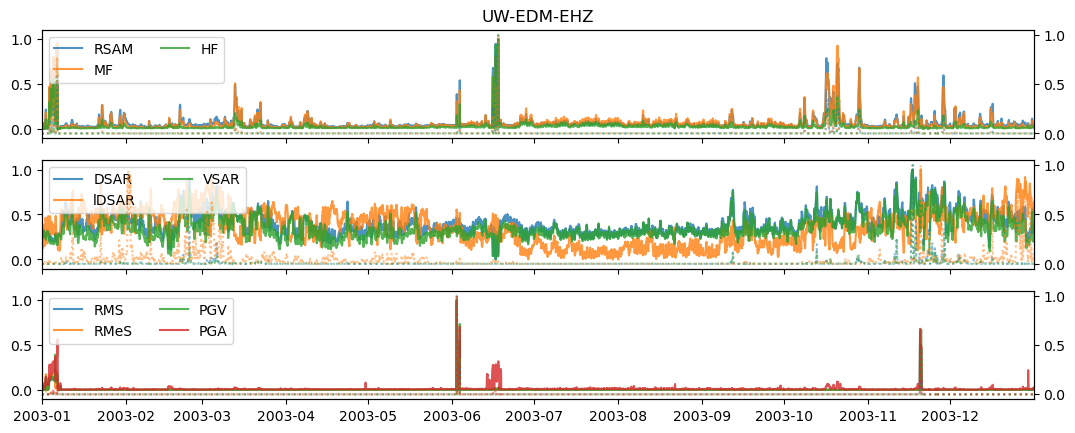

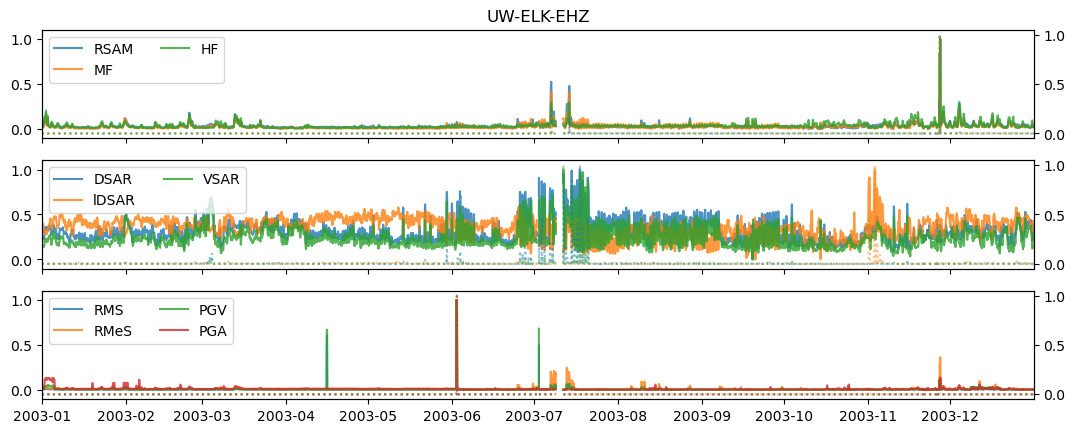

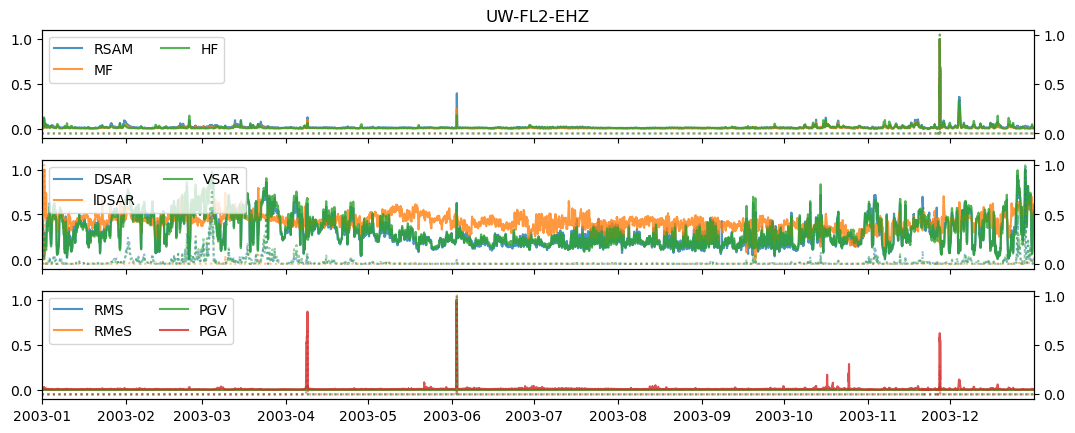

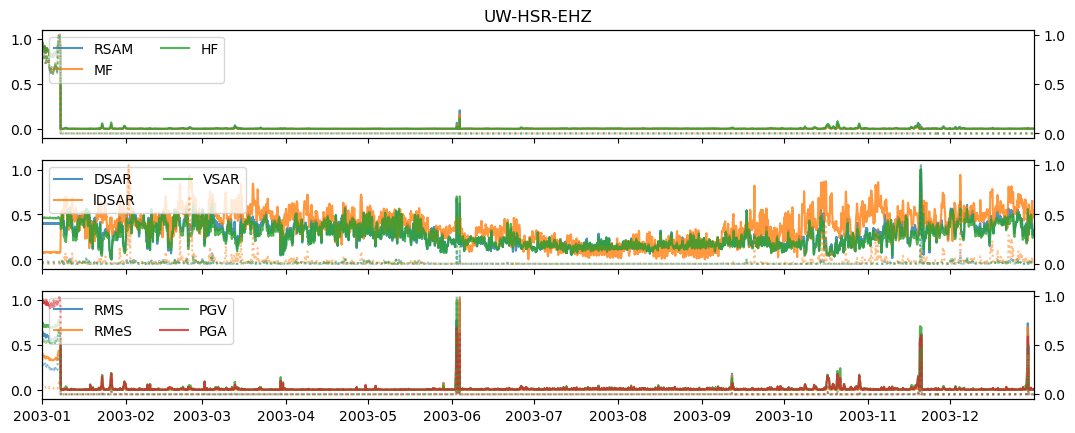

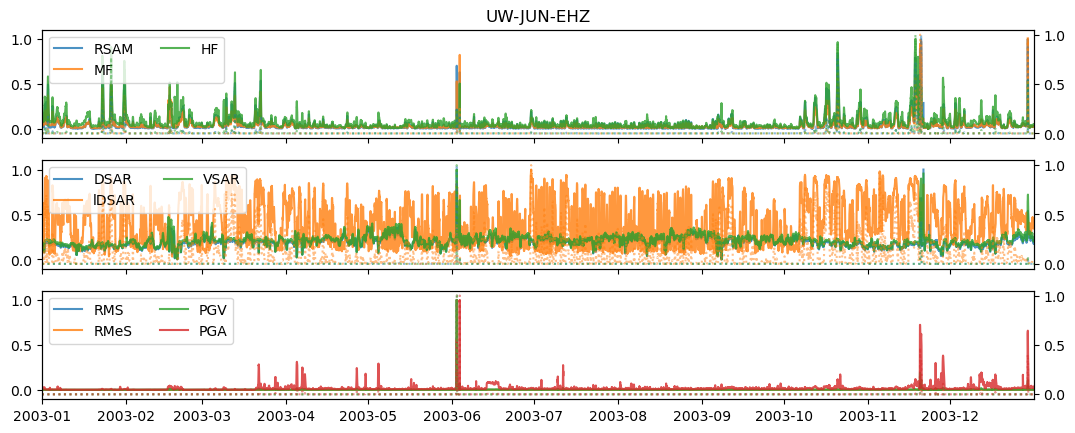

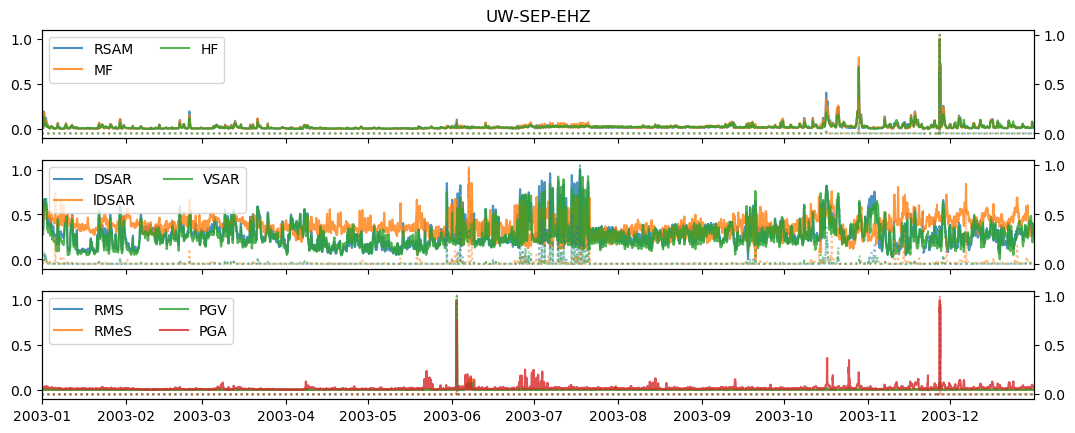

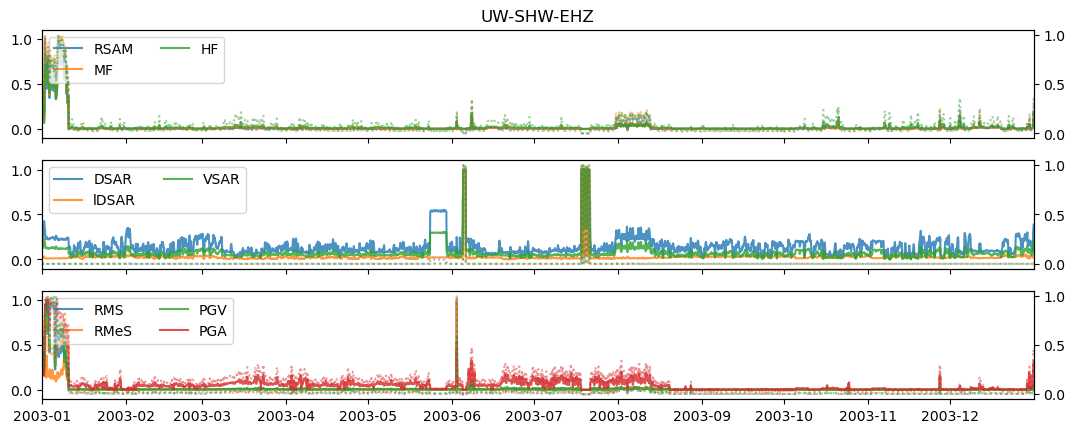

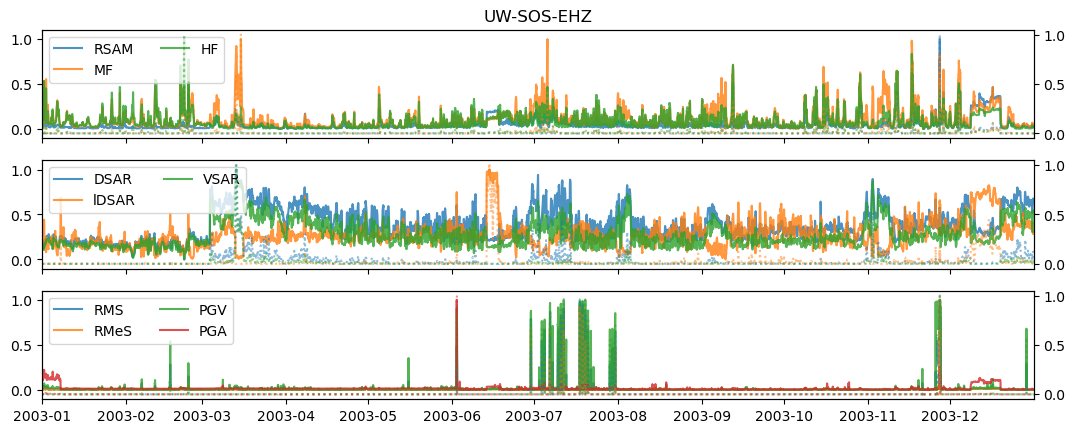

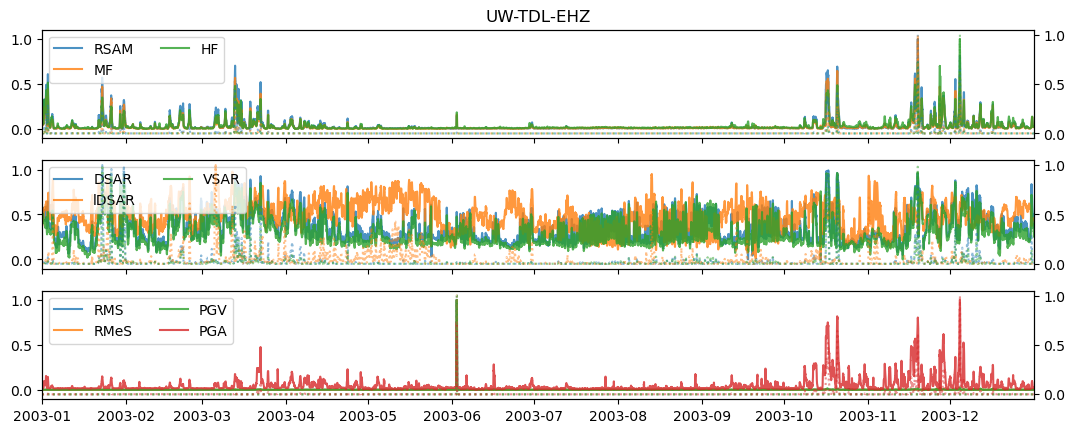

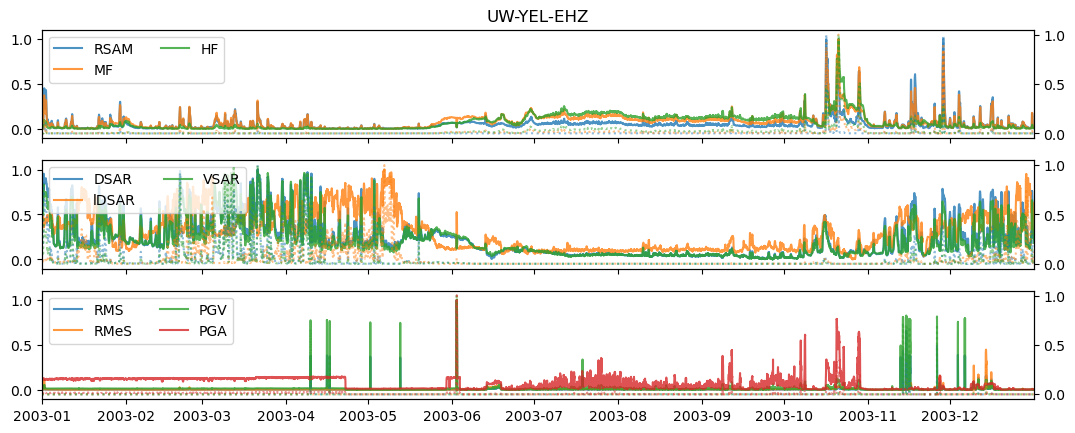

In [242]:
# NORMALIZED plot
year = 2004
sta_list = ['SEP']
# or for all avaivable stations
# all_files = sorted(glob.glob('../data/{}_*_extended2.csv'.format(year)))
# sta_list = np.unique([file.split('/')[2].split('_')[1] for file in all_files])
#============================================================================================
for sta in sta_list:
    df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta)) # read data from csv
#     df = pd.read_csv('../{}_extended2_long.csv'.format(sta))
    df.set_index('time',inplace=True) # set time as index
    df.index = pd.to_datetime(df.index).tz_localize(None) # convert time to datetime
    df = df.resample('10min').median() # resample to 10 min if data gaps
    
    df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)
        
    df = df.rolling('6H', center=True).median() # roll over 6 hours and take median (whole df)
#     df = df.resample('1H').median() # resample over 1 hour and take median (whole df)
    # roll over 2 days and take median (column of interest)
    df['rsam_median'] = df['rsam'].rolling('2D').median() 
    df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
    df['dsar_median'] = df['dsar'].rolling('2D').median()
    df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
    df['rms_median'] = df['rms'].rolling('2D').median()
    df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
    df['pga_median'] = df['pga'].rolling('2D').median()
    df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()

    df = df.apply(norm,axis=0) # normalize all timesiries individual
    
# start plotting ========================================================================================
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, sharex=True, figsize=(6.4*2, 4.8*1.5))
    
    # first subplot left side ---------------------------------------------------------------------------
    ax1.plot(df['rsam'], label='RSAM', alpha=0.8)
    ax1.plot(df['mf'], label='MF', alpha=0.8)
    ax1.plot(df['hf'], label='HF', alpha=0.8)
    ax1.plot(df['rsam_median'], label='RSAM med',color='k')

    # first subplot right side ---------------------------------------------------------------------------
    ax11 = ax1.twinx()
    ax11.plot(df['zsc2_rsam'],linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_mf'], linestyle=':', alpha=0.5)
    ax11.plot(df['zsc2_hf'], linestyle=':', alpha=0.5)

    # second subplot left side ---------------------------------------------------------------------------
    ax2.plot(df['dsar'], label='DSAR', alpha=0.8)
    ax2.plot(df['ldsar'], label='lDSAR', alpha=0.8)
    ax2.plot(df['vsar'], label='VSAR', alpha=0.8)
    ax2.plot(df['dsar_median'], label='DSAR med',color='k')

    # second subplot right side ---------------------------------------------------------------------------
    ax22 = ax2.twinx()
    ax22.plot(df['zsc2_dsar'],linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_ldsar'], linestyle=':', alpha=0.5)
    ax22.plot(df['zsc2_vsar'], linestyle=':', alpha=0.5)
#     ax2.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
#     ax2.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')

    # third subplot left side ---------------------------------------------------------------------------
    ax3.plot(df['rms'], label='RMS', alpha=0.8)
    ax3.plot(df['rmes'], label='RMeS', alpha=0.8)
    ax3.plot(df['rms_median'], label='RMS med',color='k')
#     ax3.plot(df['pgv'], label='PGV', alpha=0.8)
#     ax3.plot(df['pga'], label='PGA', alpha=0.8)

    # third subplot right side ---------------------------------------------------------------------------
    ax33 = ax3.twinx()
    ax33.plot(df['zsc2_rms'],linestyle=':', alpha=0.5)
    ax33.plot(df['zsc2_rmes'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
#     ax33.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)

    # fourth subplot left side ---------------------------------------------------------------------------
    ax4.plot(df['pgv'], label='PGV', alpha=0.8)
    ax4.plot(df['pga'], label='PGA', alpha=0.8)
    ax4.plot(df['pga_median'], label='PGA med',color='k')

    # fourth subplot right side ---------------------------------------------------------------------------
    ax44 = ax4.twinx()
    ax44.plot(df['zsc2_pgv'], linestyle=':', alpha=0.5)
    ax44.plot(df['zsc2_pga'], linestyle=':', alpha=0.5)
    
    # vertical line fror eruption date ----------------------------------------------------------------
    ax1.vlines(UTCDateTime('2004-09-23T09:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-09-23T09:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-09-23T09:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-09-23T09:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')
    
    ax1.vlines(UTCDateTime('2004-10-01T19:00:00'),ax1.get_ylim()[0],ax1.get_ylim()[-1], 'k','--')
    ax2.vlines(UTCDateTime('2004-10-01T19:00:00'),ax2.get_ylim()[0],ax2.get_ylim()[-1], 'k','--')
    ax3.vlines(UTCDateTime('2004-10-01T19:00:00'),ax3.get_ylim()[0],ax3.get_ylim()[-1], 'k','--')
    ax4.vlines(UTCDateTime('2004-10-01T19:00:00'),ax4.get_ylim()[0],ax4.get_ylim()[-1], 'k','--')

    # legend  ---------------------------------------------------------------------------
    ax1.legend(ncol=2, loc='upper left')
    ax2.legend(ncol=2, loc='upper left')
    ax3.legend(ncol=2, loc='upper left')
    ax4.legend(ncol=2, loc='upper left')
    
    ax1.set_title('Station {}'.format(sta))
    
#     file_path = '../plots/{}/'.format(year)
#     if not os.path.exists(file_path): # create path if not exist
#         os.makedirs(file_path)
#     plt.savefig('../plots/{}/{}_{}_norm.png'.format(year,year,sta), dpi=300, bbox_inches='tight')

    fig.show()

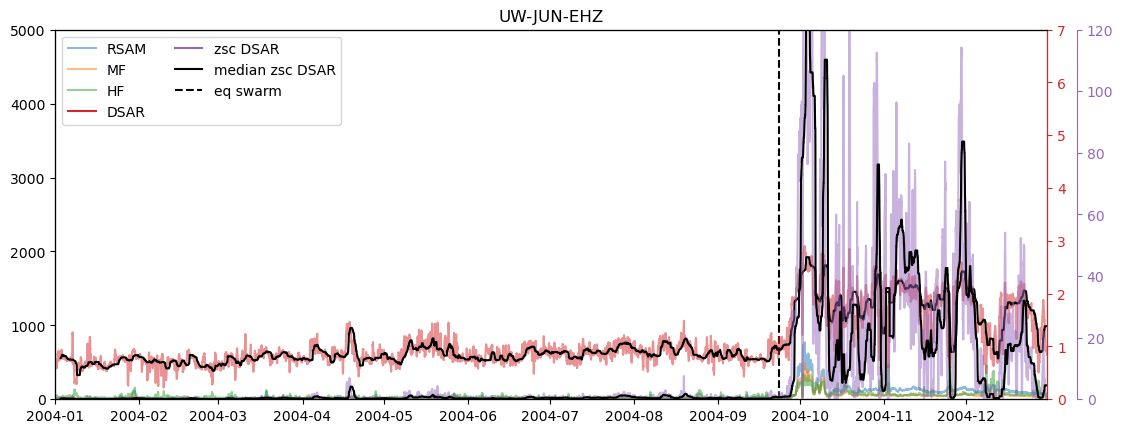

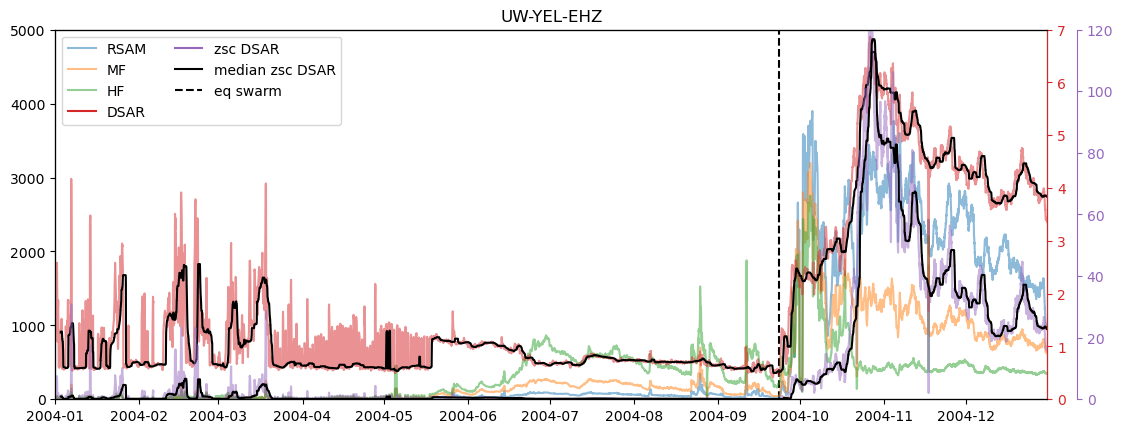

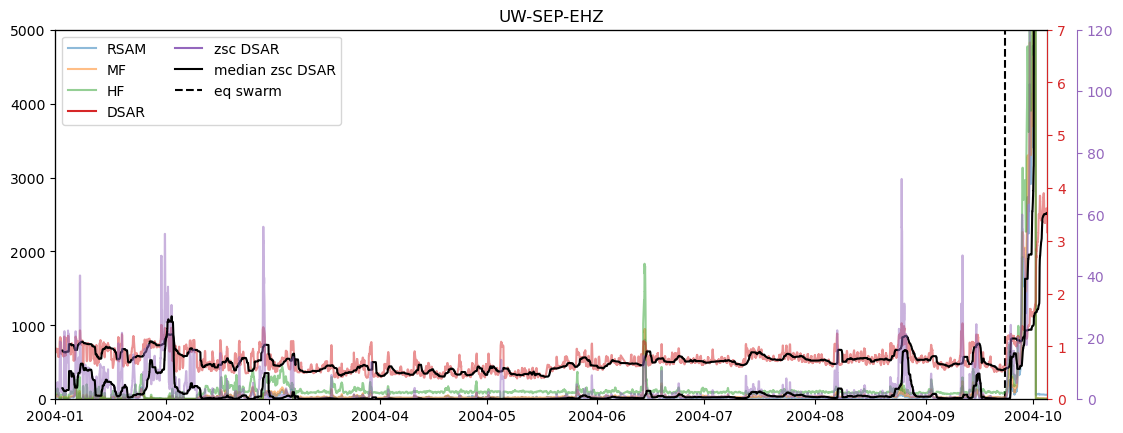

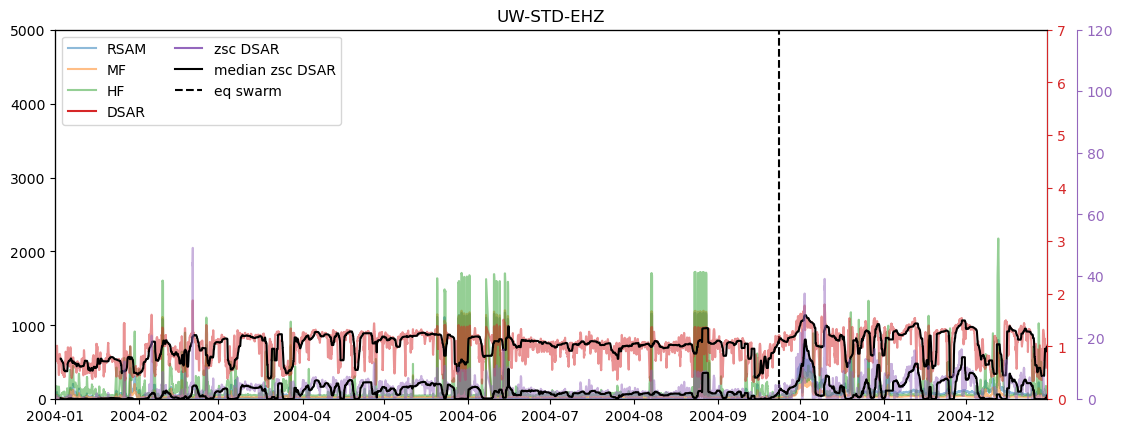

In [121]:
sta_list = ['JUN','YEL','SEP','STD','EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF']
for sta in sta_list:
#     all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/{}/*.csv'.format(sta)))
#     li = []
#     for filename in all_files:
#         frame = pd.read_csv(filename)
#         li.append(frame)

#     df = pd.concat(li, axis=0, ignore_index=True)
#     df.set_index('time',inplace=True)
#     df.index = pd.to_datetime(df.index).tz_localize(None)
#     df.sort_index()

#     # compute transforms and save
#     df['zsc2_rsam'] = zsc2(df['rsam'])
#     df['zsc2_mf'] = zsc2(df['mf'])
#     df['zsc2_hf'] = zsc2(df['hf'])
#     df['zsc2_dsar'] = zsc2(df['dsar'])

#     df.to_csv('../{}_extended.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')
       
    df = pd.read_csv('../{}_extended.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.rolling('6H', center=True).median()
    df['dsar_median'] = df[['dsar']].rolling(2*24*6).median()
    df['zsc2_dsar_median'] = df[['zsc2_dsar']].rolling(2*24*6).median()
    # df = df.resample('1H').median()

    fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

    ax.plot(df['rsam'], label='RSAM', alpha=0.5)
    ax.plot(df['mf'], label='MF', alpha=0.5)
    ax.plot(df['hf'], label='HF', alpha=0.5)
    ax.plot(np.nan, label='DSAR')
    ax.plot(np.nan, label='zsc DSAR')
    ax.plot(np.nan, label='median zsc DSAR', color='k')
    ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
    ax.set_ylim(0,5e3) # linear
    # ax.set_ylim(1e-2,1e4) # log
    # ax.set_yscale('log')

    ax2 = ax.twinx()
    ax2.spines.right.set_color('C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.tick_params(axis='y', colors='C3')
    ax2.plot(df['dsar'], label='DSAR', color='C3', alpha=0.5)
    ax2.plot(df['dsar_median'], label='median DSAR', color='k')
    ax2.set_ylim(0,7)

    ax3 = ax.twinx()
    ax3.spines.right.set_position(("axes", 1.03))
    ax3.spines.right.set_color('C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.tick_params(axis='y', colors='C4')
    ax3.plot(df['zsc2_dsar'], label='zscDSAR', color='C4', alpha=0.5)
    ax3.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')
    ax3.set_ylim(0,120)

    ax.set_xlim(df.index[0], df.index[-1])
    ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

    ax.set_title('UW-{}-EHZ'.format(sta))
    ax.legend(ncol=2, loc='upper left')
    fig.show()

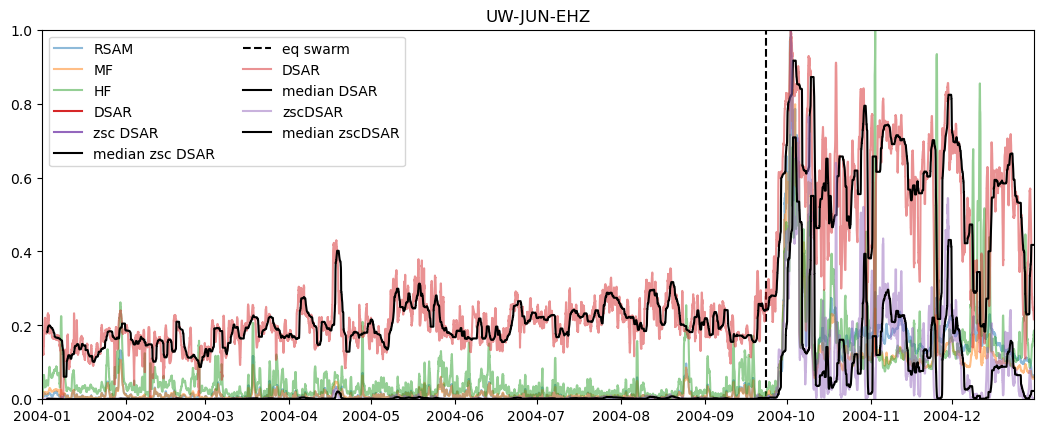

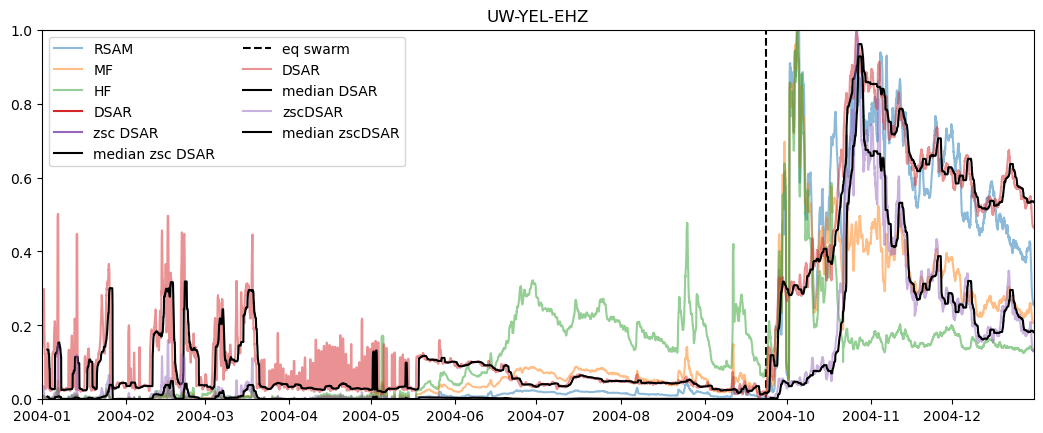

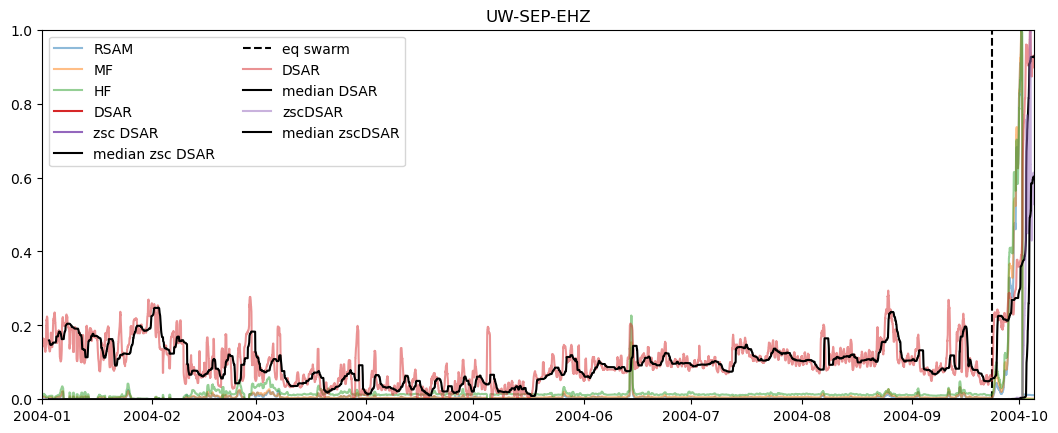

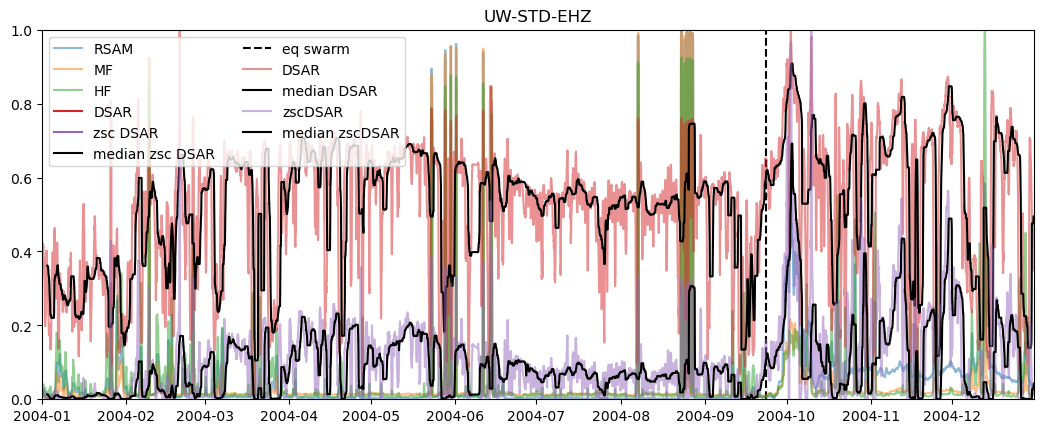

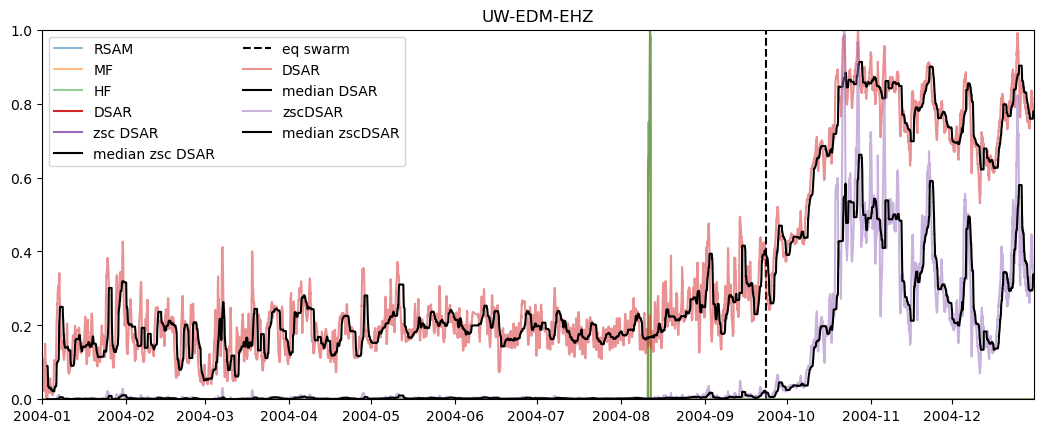

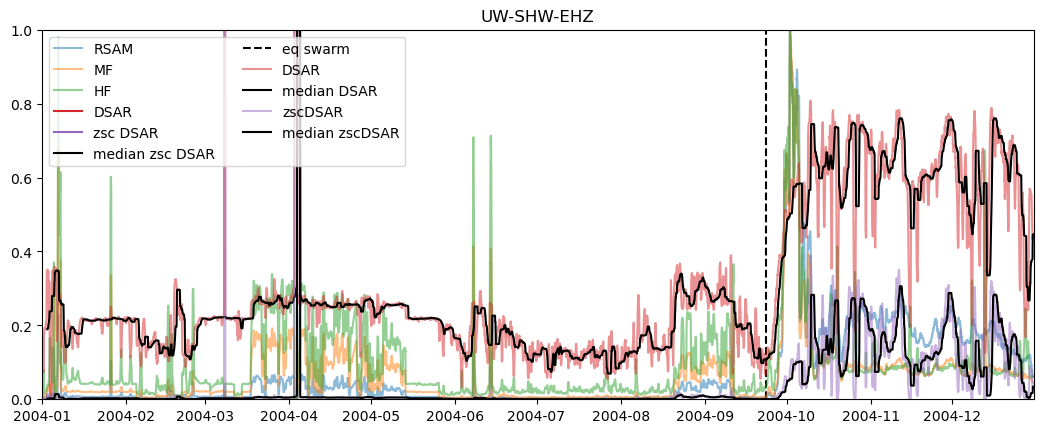

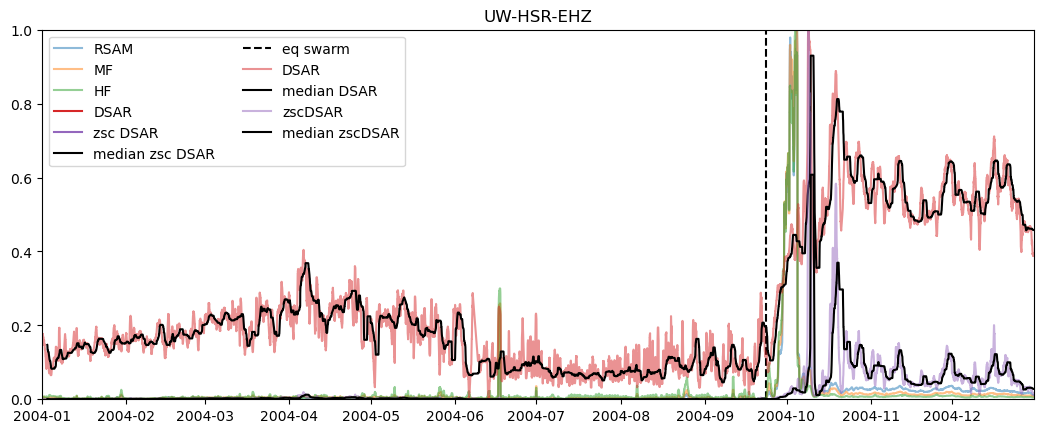

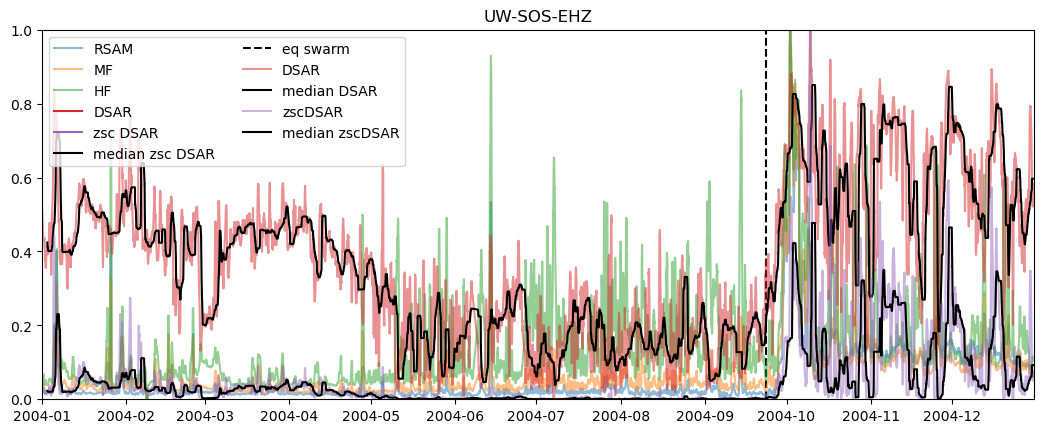

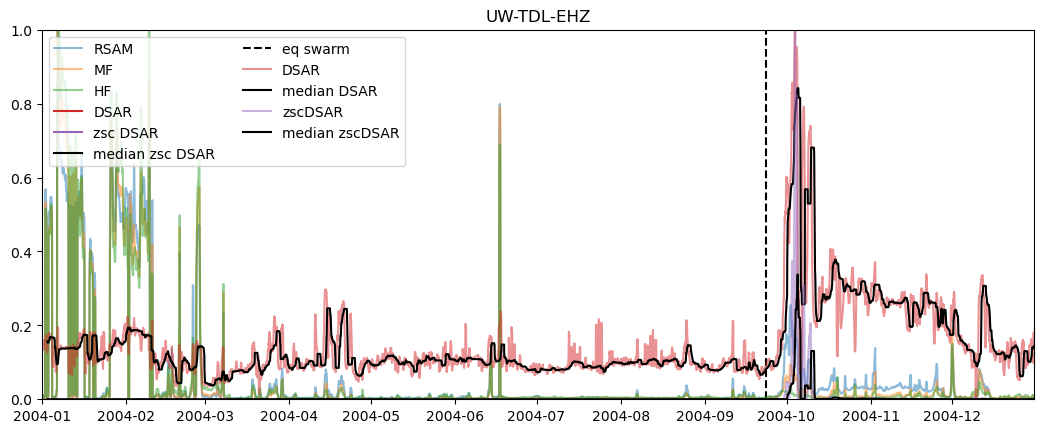

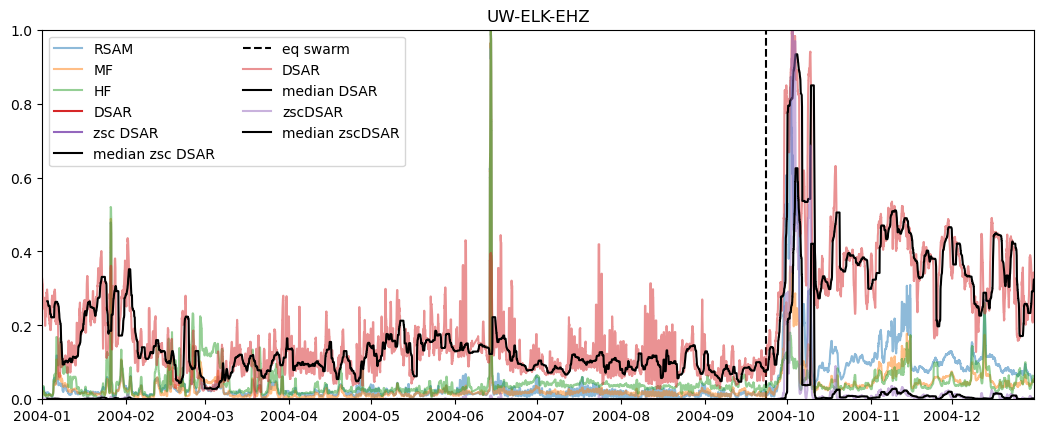

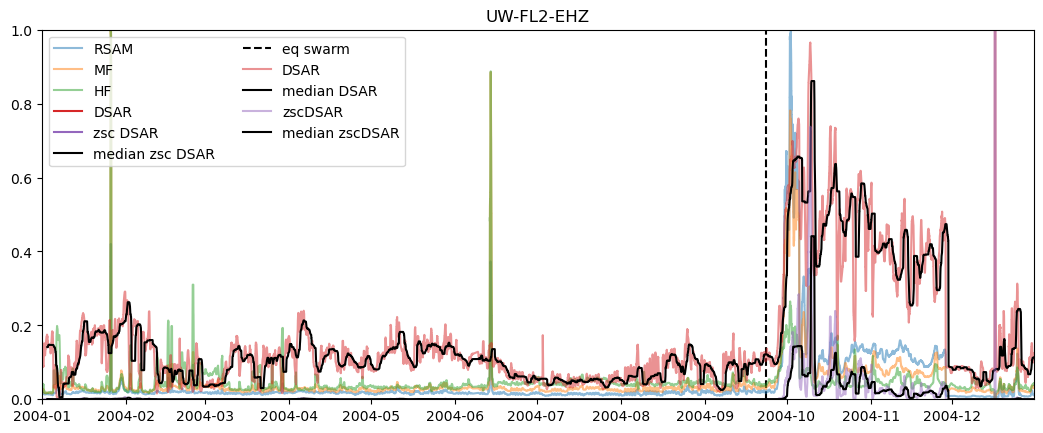

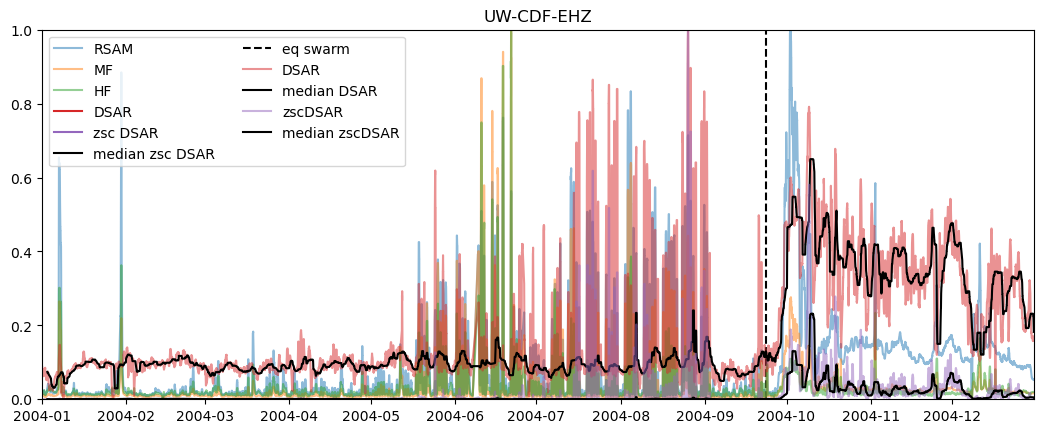

In [126]:
# NORMALIZATION
df_dsar_median = pd.DataFrame()
df_zscdsar_median = pd.DataFrame()

sta_list = ['JUN','YEL','SEP','STD','EDM','SHW','HSR','SOS','TDL','ELK','FL2','CDF']
for sta in sta_list:
#     all_files = sorted(glob.glob('/data/wsd03/data_manuela/MtStHelens/RSAM_DSAR/2004/{}/*.csv'.format(sta)))
#     li = []
#     for filename in all_files:
#         frame = pd.read_csv(filename)
#         li.append(frame)

#     df = pd.concat(li, axis=0, ignore_index=True)
#     df.set_index('time',inplace=True)
#     df.index = pd.to_datetime(df.index).tz_localize(None)
#     df.sort_index()

#     # compute transforms and save
#     df['zsc2_rsam'] = zsc2(df['rsam'])
#     df['zsc2_mf'] = zsc2(df['mf'])
#     df['zsc2_hf'] = zsc2(df['hf'])
#     df['zsc2_dsar'] = zsc2(df['dsar'])

#     df.to_csv('../{}_extended.csv'.format(sta)) #df.to_csv('.'+os.sep+'SHW_seismic_data_extended.csv')
    
    
    df = pd.read_csv('../{}_extended.csv'.format(sta))
    df.set_index('time',inplace=True)
    df.index = pd.to_datetime(df.index).tz_localize(None)
    df = df.rolling('12H', center=True).median()
    df['dsar_median'] = norm(df['dsar']).rolling(2*24*6).median()
    df['zsc2_dsar_median'] = norm(df['zsc2_dsar']).rolling(2*24*6).median()
    # df = df.resample('1H').median()
    df_dsar_median['{}'.format(sta)] = df['dsar_median']
    df_zscdsar_median['{}'.format(sta)] = df['zsc2_dsar_median']

    fig, ax = plt.subplots(1,1, sharex=True, figsize=(6.4*2, 4.8))

    ax.plot(norm(df['rsam']), label='RSAM', alpha=0.5)
    ax.plot(norm(df['mf']), label='MF', alpha=0.5)
    ax.plot(norm(df['hf']), label='HF', alpha=0.5)
    ax.plot(np.nan, label='DSAR')
    ax.plot(np.nan, label='zsc DSAR')
    ax.plot(np.nan, label='median zsc DSAR', color='k')
    ax.plot(np.nan, label='eq swarm', color='k',linestyle='--')
#     ax.set_ylim(0,5e3) # linear
    # ax.set_ylim(1e-2,1e4) # log
    # ax.set_yscale('log')

    ax.plot(norm(df['dsar']), label='DSAR', color='C3', alpha=0.5)
    ax.plot(df['dsar_median'], label='median DSAR', color='k')
#     ax2.set_ylim(0,7)

    ax.plot(norm(df['zsc2_dsar']), label='zscDSAR', color='C4', alpha=0.5)
    ax.plot(df['zsc2_dsar_median'], label='median zscDSAR', color='k')
#     ax3.set_ylim(0,120)
    ax.set_ylim(0,1)
    ax.set_xlim(df.index[0], df.index[-1])
    ax.vlines(UTCDateTime('2004-09-23T09:00:00'),ax.get_ylim()[0],ax.get_ylim()[-1], 'k','--')

    ax.set_title('UW-{}-EHZ'.format(sta))
    ax.legend(ncol=2, loc='upper left')
    fig.show()

## Multi-Station plots

In [99]:
plt.rcParams["figure.figsize"] = (6.4*2, 4.8)

### Calculate the distance between the stations and a reference station

In [105]:
def distance(lat1, lat2, lon1, lon2):
    '''input: latitude and longitude of two points in degree
       output: distance between two points in kilometers'''
     
    # The math module contains a function named
    # radians which converts from degrees to radians.
    lon1 = math.radians(lon1)
    lon2 = math.radians(lon2)
    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)
      
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
 
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of earth in kilometers. Use 3956 for miles
    r = 6371
      
    # calculate the result
    return(c * r)

In [120]:
# load station coordinates and drop the stations which are not of interresst
all_files = sorted(glob.glob('../data/*_*_extended2.csv'))
sta_list = np.unique([file.split('/')[2].split('_')[1] for file in all_files]) # stations with data

df = pd.read_csv('/home/koepflma/project1/Mt-St-Helens/sta_log_long.txt', sep='|', header=0) # coordinates
df = df[~df['Station'].isin(list(set(df.Station)-set(sta_list)))] # delete Stations which are not of interresst
df = df.drop_duplicates(subset=['Station']) # drop one station if the station is not unique
df = df.reset_index(drop=True)
df

Network Station   latitude   longitude  Elevation  \
0       CC    BLIS  46.197472 -122.186569    2116.00   
1       CC     HOA  46.241780 -122.191830    1151.00   
2       CC     JRO  46.275270 -122.218260    1219.00   
3       CC     LOO  46.223750 -122.184390    1521.35   
4       CC    MIDE  46.197750 -122.187439    2132.00   
5       CC     NED  46.200249 -122.185493    2060.00   
6       CC    RAFT  46.195679 -122.186317    2132.00   
7       CC     REM  46.200200 -122.185500    1905.44   
8       CC     SEP  46.199780 -122.190857    2114.00   
9       CC    SPN5  46.194698 -122.188370    2263.00   
10      CC     STD  46.237490 -122.224210    1189.00   
11      CC     SUG  46.215549 -122.176262    1859.00   
12      CC    SWFL  46.188670 -122.202030    2268.00   
13      CC    USFR  46.215333 -122.232778    1341.75   
14      CC    VALT  46.214218 -122.189247    1681.00   
15      UW     CDF  46.117120 -122.046250     772.00   
16      UW     EDM  46.197170 -122.151210    1611.00   
17      UW     ELK  46.305970 -122.341670    1270.00   
18      UW     FL2  46.196220 -122.351486    1378.00   
19      UW     HSR  46.174280 -122.180650    1720.00   
20      UW     JUN  46.147060 -122.152428    1049.00   
21      UW     SHW  46.193640 -122.234920    1442.00   
22      UW     SOS  46.243858 -122.137871    1270.00   
23      UW     TDL  46.350670 -122.217040    1400.00   
24      UW     YEL  46.209549 -122.188988    1750.00   

                                          Sitename            StartTime  \
0               Blister, Mt. St. Helens (Dome sta)  2004-10-12T00:00:00   
1                                            Hoala  2021-06-08T00:00:00   
2                       Johnston Ridge Observatory  2004-10-02T00:00:00   
3                                           Loowit  2021-06-08T00:00:00   
4                                Near old BLIS MSH  2005-02-16T00:00:00   
5   NE part of old Dome, Mt. St. Helens (Dome sta)  2004-11-20T00:00:00   
6                           RAFT, St Helens Crater  2005-07-28T00:00:00   
7                       Rembrant, Mount St. Helens  2018-07-25T00:00:00   
8        September lobe, Mt. St. Helens (Dome sta)  2004-11-05T00:00:00   
9                    Spine 5, St Helens Crater, WA  2007-06-18T00:00:00   
10              Studebaker Ridge, Mount St. Helens  2004-10-05T00:00:00   
11                                      Sugar Bowl  2009-08-07T00:00:00   
12                                 Southwest Flank  2006-10-01T00:00:00   
13                       Upper South Fork Repeater  2022-06-30T00:00:00   
14                         Vault, Mount St. Helens  2006-09-30T00:00:00   
15                       Cedar Flats, MSH, WA, USA  1980-03-29T00:00:00   
16              East Dome, Mt. St. Helens, WA, USA  1980-06-01T00:00:00   
17                 Mt St Helens, Elk Rock, WA, USA  1980-05-16T00:00:00   
18                             Flat Top 2, WA, USA  1984-08-03T00:00:00   
19            South Ridge, Mt. St. Helens, WA, USA  1985-08-12T00:00:00   
20                June Lake previous ISC code: JLK  1980-05-08T00:00:00   
21                    Mt. St. Helens West, WA, USA  1972-10-01T00:00:00   
22   Source of Smith Creek previous ISC code: SOSW  1980-05-16T00:00:00   
23                       Tradedollar Lake, WA, USA  1983-11-12T00:00:00   
24                     Yellow Rock, Mt. St. Helens  1981-10-01T00:00:00   

                EndTime  
0   2005-02-17T00:00:00  
1   2599-12-31T23:59:59  
2   2599-12-31T23:59:59  
3   2599-12-31T23:59:59  
4   2005-07-26T00:00:00  
5   2013-05-01T00:00:00  
6   2007-12-31T00:00:00  
7   2599-12-31T23:59:59  
8   2599-12-31T23:59:59  
9   2007-12-31T00:00:00  
10  2599-12-31T23:59:59  
11  2599-12-31T23:59:59  
12  2013-08-28T00:00:00  
13  2599-12-31T23:59:59  
14  2599-12-31T23:59:59  
15  2599-12-31T23:59:59  
16  2599-12-31T23:59:59  
17  2599-12-31T23:59:59  
18  2599-12-31T23:59:59  
19  2599-12-31T23:59:59  
20  2599-12-31T23:59:59  
21  2599-12-31T23:59:59

In [121]:
ref_sta = 'SEP' # define the reference station, we will get distance from all other stations to this station
df['dist'] = df.apply(lambda x: distance(x['latitude'],df.latitude[df['Station']==ref_sta] , x['longitude'],df.longitude[df['Station']==ref_sta] ), axis=1)
df = df.sort_values(by=['dist'])
sta_sorted = df['Station'].to_list()
df

Network Station   latitude   longitude  Elevation  \
8       CC     SEP  46.199780 -122.190857    2114.00   
4       CC    MIDE  46.197750 -122.187439    2132.00   
7       CC     REM  46.200200 -122.185500    1905.44   
5       CC     NED  46.200249 -122.185493    2060.00   
0       CC    BLIS  46.197472 -122.186569    2116.00   
6       CC    RAFT  46.195679 -122.186317    2132.00   
9       CC    SPN5  46.194698 -122.188370    2263.00   
24      UW     YEL  46.209549 -122.188988    1750.00   
12      CC    SWFL  46.188670 -122.202030    2268.00   
14      CC    VALT  46.214218 -122.189247    1681.00   
11      CC     SUG  46.215549 -122.176262    1859.00   
3       CC     LOO  46.223750 -122.184390    1521.35   
19      UW     HSR  46.174280 -122.180650    1720.00   
16      UW     EDM  46.197170 -122.151210    1611.00   
21      UW     SHW  46.193640 -122.234920    1442.00   
13      CC    USFR  46.215333 -122.232778    1341.75   
1       CC     HOA  46.241780 -122.191830    1151.00   
10      CC     STD  46.237490 -122.224210    1189.00   
22      UW     SOS  46.243858 -122.137871    1270.00   
20      UW     JUN  46.147060 -122.152428    1049.00   
2       CC     JRO  46.275270 -122.218260    1219.00   
18      UW     FL2  46.196220 -122.351486    1378.00   
15      UW     CDF  46.117120 -122.046250     772.00   
17      UW     ELK  46.305970 -122.341670    1270.00   
23      UW     TDL  46.350670 -122.217040    1400.00   

                                          Sitename            StartTime  \
8        September lobe, Mt. St. Helens (Dome sta)  2004-11-05T00:00:00   
4                                Near old BLIS MSH  2005-02-16T00:00:00   
7                       Rembrant, Mount St. Helens  2018-07-25T00:00:00   
5   NE part of old Dome, Mt. St. Helens (Dome sta)  2004-11-20T00:00:00   
0               Blister, Mt. St. Helens (Dome sta)  2004-10-12T00:00:00   
6                           RAFT, St Helens Crater  2005-07-28T00:00:00   
9                    Spine 5, St Helens Crater, WA  2007-06-18T00:00:00   
24                     Yellow Rock, Mt. St. Helens  1981-10-01T00:00:00   
12                                 Southwest Flank  2006-10-01T00:00:00   
14                         Vault, Mount St. Helens  2006-09-30T00:00:00   
11                                      Sugar Bowl  2009-08-07T00:00:00   
3                                           Loowit  2021-06-08T00:00:00   
19            South Ridge, Mt. St. Helens, WA, USA  1985-08-12T00:00:00   
16              East Dome, Mt. St. Helens, WA, USA  1980-06-01T00:00:00   
21                    Mt. St. Helens West, WA, USA  1972-10-01T00:00:00   
13                       Upper South Fork Repeater  2022-06-30T00:00:00   
1                                            Hoala  2021-06-08T00:00:00   
10              Studebaker Ridge, Mount St. Helens  2004-10-05T00:00:00   
22   Source of Smith Creek previous ISC code: SOSW  1980-05-16T00:00:00   
20                June Lake previous ISC code: JLK  1980-05-08T00:00:00   
2                       Johnston Ridge Observatory  2004-10-02T00:00:00   
18                             Flat Top 2, WA, USA  1984-08-03T00:00:00   
15                       Cedar Flats, MSH, WA, USA  1980-03-29T00:00:00   
17                 Mt St Helens, Elk Rock, WA, USA  1980-05-16T00:00:00   
23                       Tradedollar Lake, WA, USA  1983-11-12T00:00:00   

                EndTime       dist  
8   2599-12-31T23:59:59   0.000000  
4   2005-07-26T00:00:00   0.346634  
7   2599-12-31T23:59:59   0.414926  
5   2013-05-01T00:00:00   0.416109  
0   2005-02-17T00:00:00   0.418066  
6   2007-12-31T00:00:00   0.574494  
9   2007-12-31T00:00:00   0.596632  
24  2007-09-18T00:00:00   1.095744  
12  2013-08-28T00:00:00   1.505239  
14  2599-12-31T23:59:59   1.610206  
11  2599-12-31T23:59:59   2.082286  
3   2599-12-31T23:59:59   2.711396  
19  2599-12-31T23:59:59   2.942327  
16  2599-12-31T23:59:59   3.065199  
21  2599-12-31T23:59:59   3.459455  
13 

### Load the data

In [209]:
years = range(2000,2022+1)

df_rsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscrsam_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_dsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscdsar_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))

df_rms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscrms_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_pga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))
df_zscpga_median = pd.DataFrame(index=pd.date_range("{}-01-01".format(years[0]), "{}-01-01".format(years[-1]+1), freq="10min", inclusive='left'))


len_dates = len(df_rsam_median)
count = 0

for i,sta in enumerate(sta_sorted):
    li = []
    len_data = 0
    for year in years:
        try:
            df = pd.read_csv('../data/{}_{}_extended2.csv'.format(year,sta))
        #     df = pd.read_csv('../data/{}_extended2_long.csv'.format(sta))
            df.set_index('time',inplace=True)
            df.index = pd.to_datetime(df.index).tz_localize(None)
            df = df.resample('10min').median()
            li.append(df)
            len_data += len(df.index)
        except:
#             print(' file {}_{}_extended2.csv does not exist'.format(year,sta))
            pass
    
    if len_data > len_dates*0.25: # percent of avivable data
        df = pd.concat(li)


        df = df.apply(mask_df,axis=0) # remove outliers (the peak detection does not work well)

        df = df.rolling('6H', center=True).median()
        df['rsam_median'] = df['rsam'].rolling('2D').median()
        df['zsc2_rsam_median'] = df['zsc2_rsam'].rolling('2D').median()
        df['dsar_median'] = df['dsar'].rolling('2D').median()
        df['zsc2_dsar_median'] = df['zsc2_dsar'].rolling('2D').median()
        df['rms_median'] = df['rms'].rolling('2D').median()
        df['zsc2_rms_median'] = df['zsc2_rms'].rolling('2D').median()
        df['pga_median'] = df['pga'].rolling('2D').median()
        df['zsc2_pga_median'] = df['zsc2_pga'].rolling('2D').median()
    #     df = df.resample('1H').median()

        df = df.apply(norm,axis=0) # normalize all timesiries individual

        df += count*0.5 # to get offset

        df_rsam_median['{}'.format(sta)] = df['rsam_median']
        df_zscrsam_median['{}'.format(sta)] = df['zsc2_rsam_median']
        df_dsar_median['{}'.format(sta)] = df['dsar_median']
        df_zscdsar_median['{}'.format(sta)] = df['zsc2_dsar_median']

        df_rms_median['{}'.format(sta)] = df['rms_median']
        df_zscrms_median['{}'.format(sta)] = df['zsc2_rms_median']
        df_pga_median['{}'.format(sta)] = df['pga_median']
        df_zscpga_median['{}'.format(sta)] = df['zsc2_pga_median']
        
        count += 1
    else:
        pass
    
    sys.stdout.write('\r{} of {}'.format(i+1, len(sta_list)))
    sys.stdout.flush()
print('\nDONE')

25 of 25
DONE


### Plot

In [212]:
years[0],years[-1]

(2000, 2022)

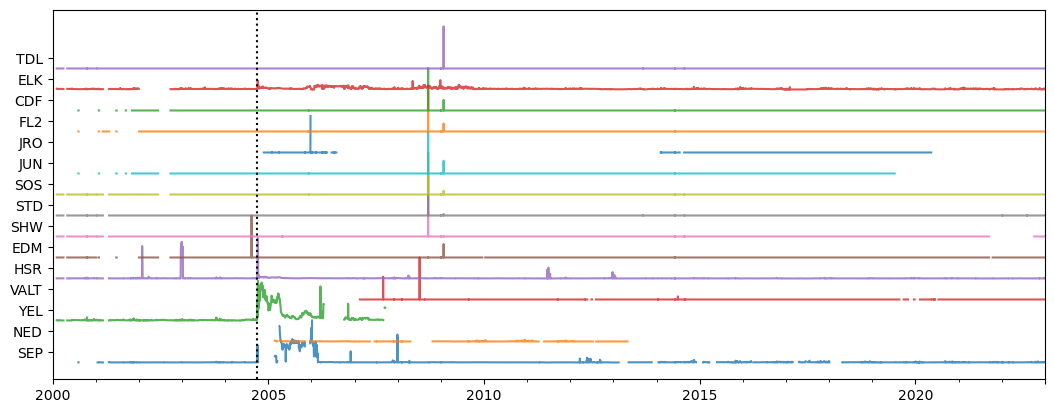

In [213]:
df_rsam_median_res = df_rsam_median.resample('1D').median()
ax = df_rsam_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_rsam_median_res.columns))/2,0.5))
ax.set_yticklabels(df_rsam_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')

# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
# plt.legend(ncol=1, loc='upper left')
plt.savefig('../plots/multiyear/{}_{}_RSAM_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

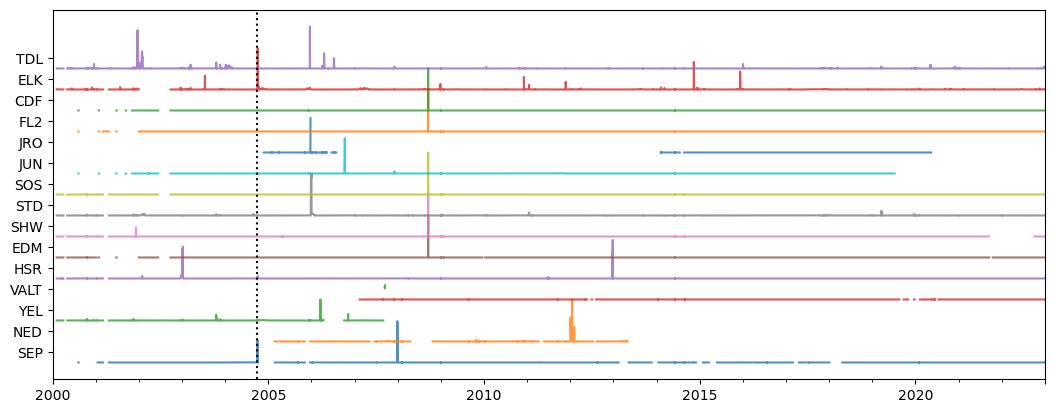

In [214]:
df_zscrsam_median_res = df_zscrsam_median.resample('1D').median()
ax = df_zscrsam_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_zscrsam_median_res.columns))/2,0.5))
ax.set_yticklabels(df_zscrsam_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

plt.savefig('../plots/multiyear/{}_{}_zscRSAM_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

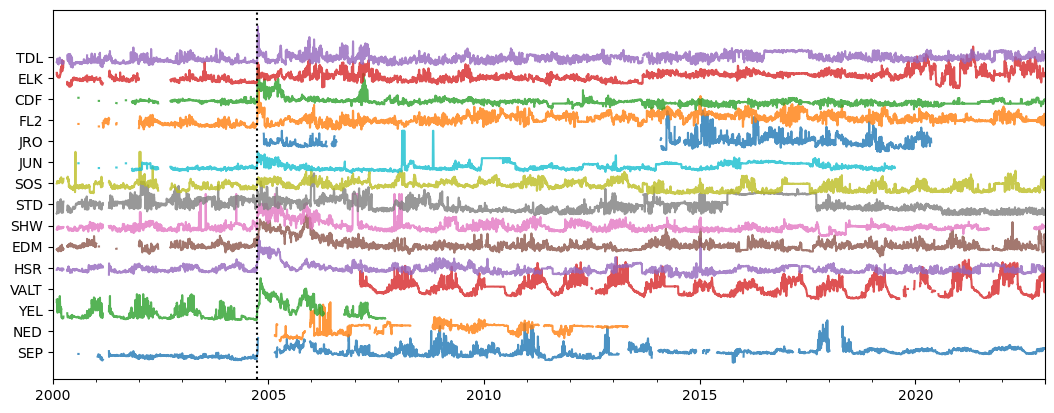

In [215]:
df_dsar_median_res = df_dsar_median.resample('1D').median()
ax = df_dsar_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_dsar_median_res.columns))/2,0.5))
ax.set_yticklabels(df_dsar_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

plt.savefig('../plots/multiyear/{}_{}_DSAR_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

In [226]:
activity_dome = df_activity.copy()
activity_dome_start = activity_dome[activity_dome['activity' ]=='d'].take([0,2,3,4,5,6])
activity_dome_end = activity_dome[activity_dome['activity' ]=='ed'].take([1,2,3,4,5,6])
activity_dome_start

activity
UTC                
2004-10-11        d
2004-10-25        d
2005-01-03        d
2005-03-19        d
2005-08-06        d
2005-10-09        d

In [227]:
activity_dome_end

activity
UTC                
2004-10-24       ed
2004-12-18       ed
2005-03-09       ed
2005-07-18       ed
2005-10-09       ed
2006-04-01       ed

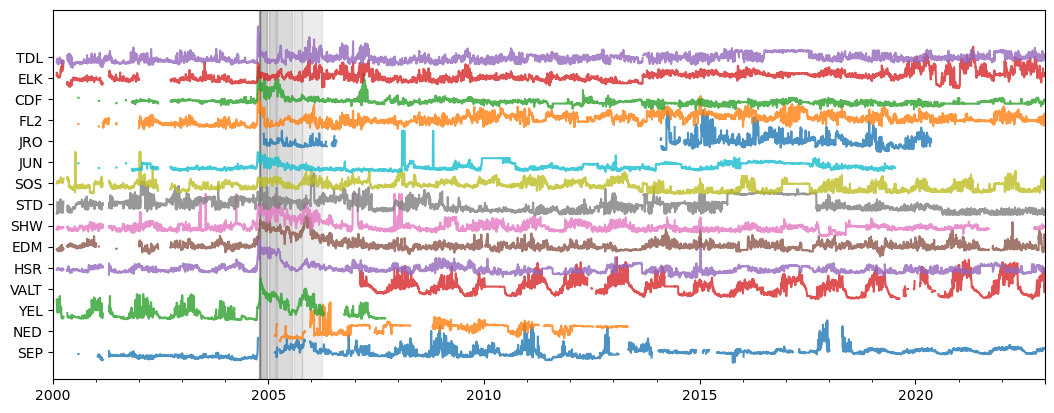

In [255]:
df_cut = df_dsar_median.copy() # change here data to plot
# df_cut = df_cut.loc[datetime.datetime(2004,1,1):datetime.datetime(2007,1,1)]
df_res = df_cut.resample('1D').median()
ax = df_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_res.columns))/2,0.5))
ax.set_yticklabels(df_res.columns)

color = cm.gray(np.linspace(0, 1, len(activity_dome_start)+2))

for i in range(len(activity_dome_start)):
    sdate = activity_dome_start.index[i].to_pydatetime() # start date
    edate = activity_dome_end.index[i].to_pydatetime() # end date
#     plt.axvline(sdate, color='k',linestyle=':')
    ax.axvspan(sdate, edate, alpha=0.25, color=color[i])
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

# plt.savefig('../plots/multiyear/2000_2022_DSAR_sorted_dome3.png', dpi=300, bbox_inches='tight')

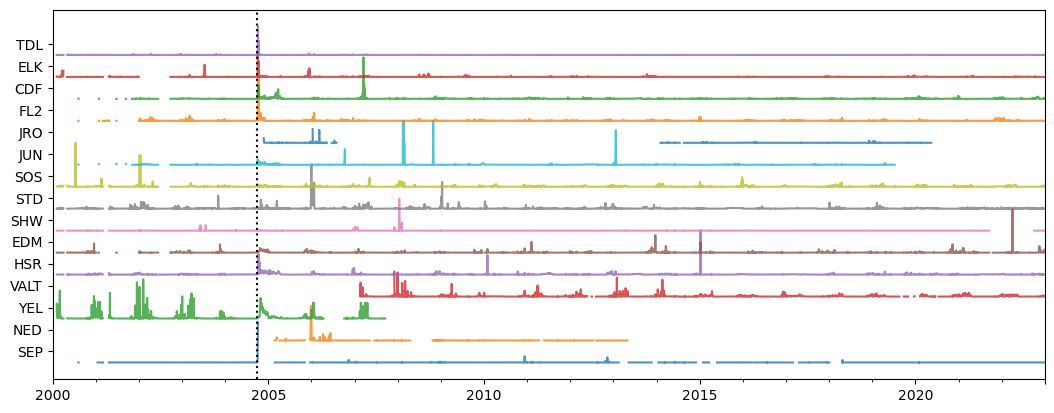

In [247]:
df_zscdsar_median_res = df_zscdsar_median.resample('1D').median()
ax = df_zscdsar_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_zscdsar_median_res.columns))/2,0.5))
ax.set_yticklabels(df_zscdsar_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

plt.savefig('../plots/multiyear/{}_{}_zscDSAR_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

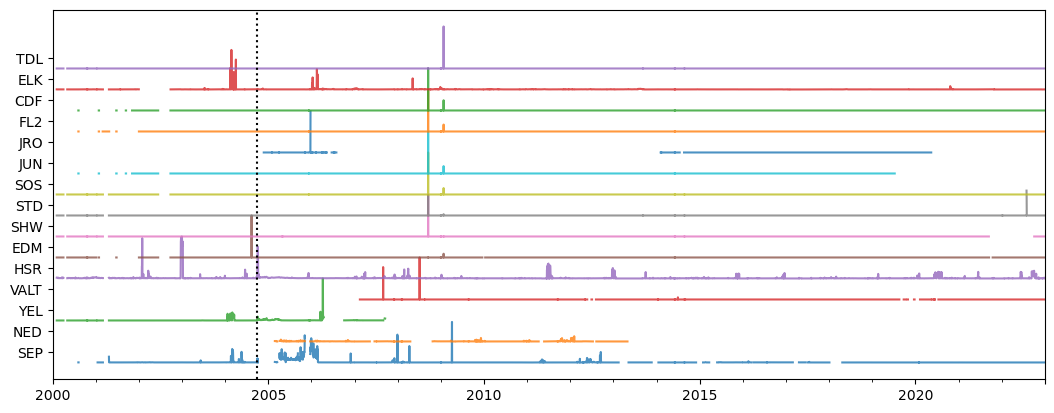

In [248]:
df_rms_median_res = df_rms_median.resample('1D').median()
ax = df_rms_median_res.plot(alpha=0.8,legend=False)

ax.set_yticks(np.arange(0.25,(len(df_rms_median_res.columns))/2,0.5))
ax.set_yticklabels(df_rms_median_res.columns)

plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle=':')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')

plt.savefig('../plots/multiyear/{}_{}_RMS_sorted.png'.format(years[0],years[-1]), dpi=300, bbox_inches='tight')

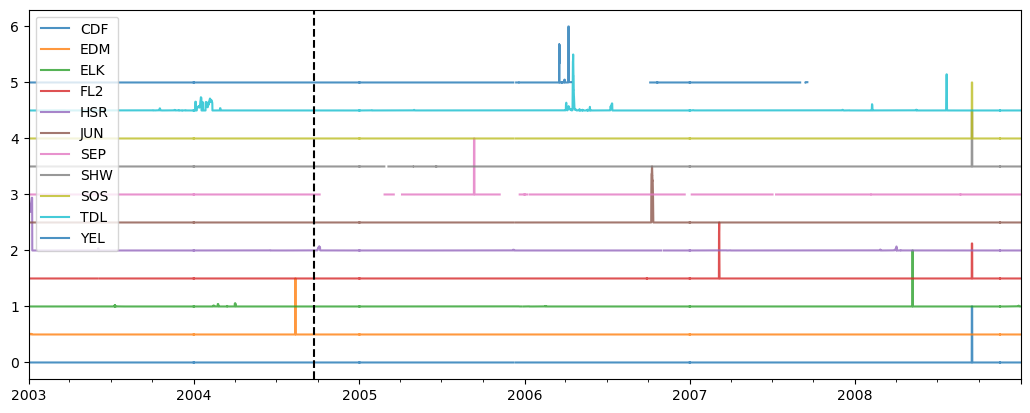

In [1000]:
df_zscrms_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

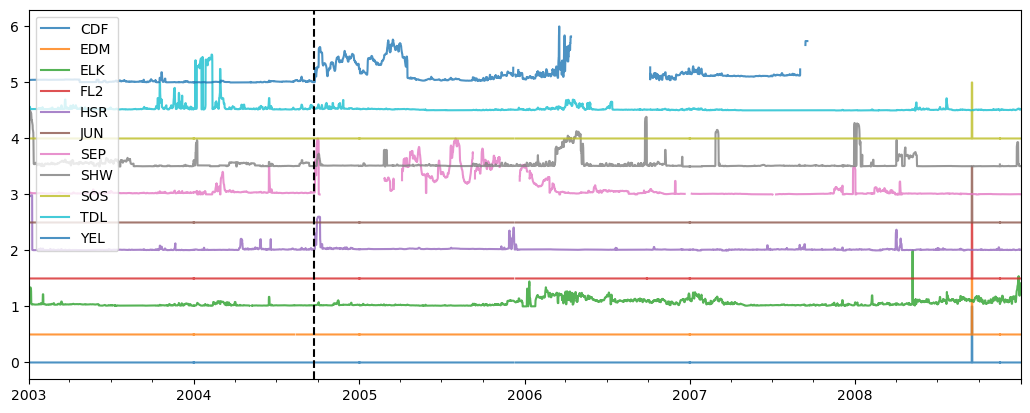

In [1001]:
df_pga_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

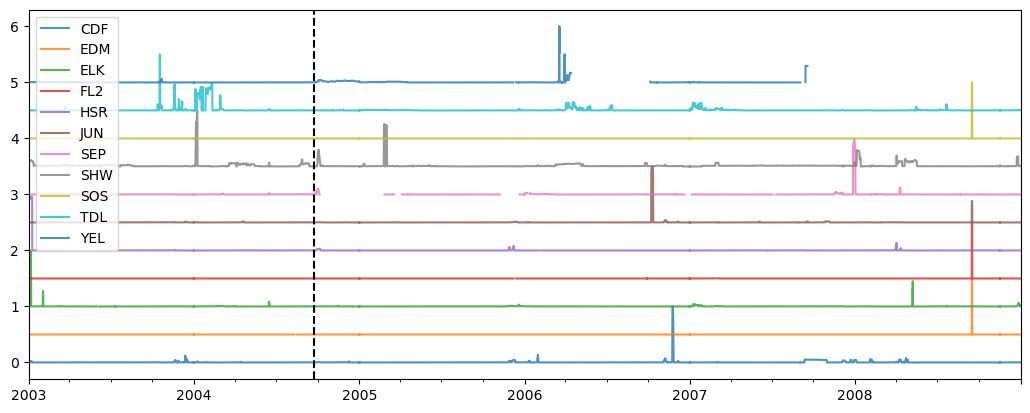

In [1002]:
df_zscpga_median.plot(alpha=0.8)
plt.axvline(datetime.datetime(2004,9,23,9), color='k',linestyle='--')
# plt.axvline(datetime.datetime(2004,10,1,19), color='k',linestyle='--')
plt.legend(ncol=1, loc='upper left')

### Sort stations by crater distance

You need to run the import cells at the beginning of the script and the cells below the title Multi-Station Plots. Then, continue here with importing the station txt and calculate the distance to the crater station SEP. For creating the plots, use again the cells above.

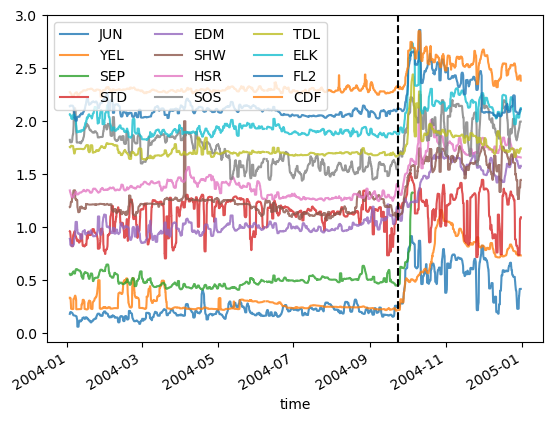

In [127]:
df_dsar_median_copy = df_dsar_median.copy()
for i in range(df_dsar_median_copy.shape[1]):
    df_dsar_median_copy.iloc[:, i] = df_dsar_median_copy.iloc[:, i]+(i*0.2)
df_dsar_median_copy.plot(alpha=0.8)
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

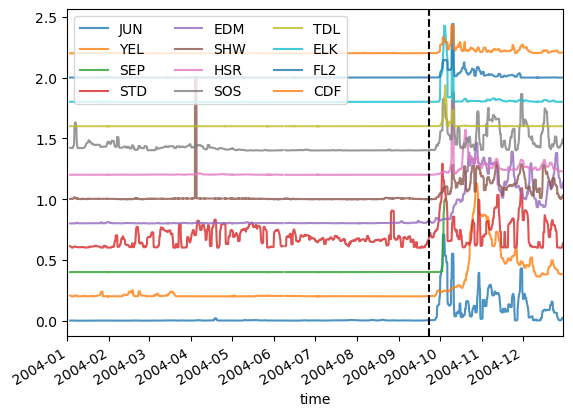

In [130]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]+(i*0.2)
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

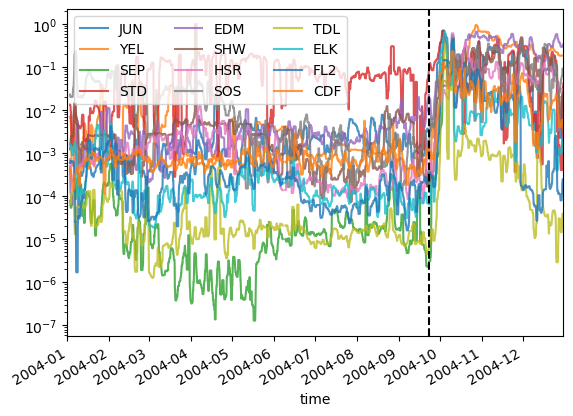

In [131]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.yscale('log')
plt.axvline(UTCDateTime('2004-09-23T09:00:00'), color='k',linestyle='--')
plt.legend(ncol=3, loc='upper left')

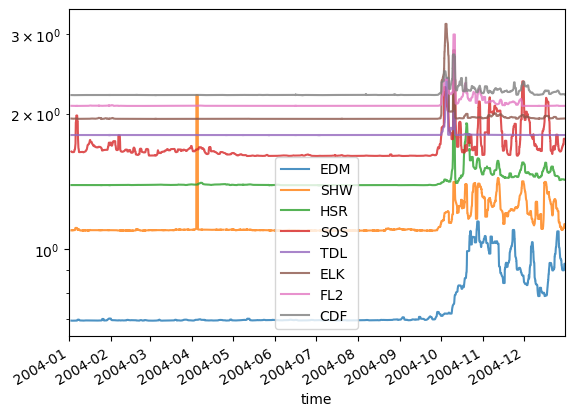

In [108]:
df_zscdsar_median_copy = df_zscdsar_median.copy()
for i in range(df_zscdsar_median_copy.shape[1]):
    df_zscdsar_median_copy.iloc[:, i] = df_zscdsar_median_copy.iloc[:, i]*np.log((i+2))+np.log((i+2))
df_zscdsar_median_copy.plot(alpha=0.8)
plt.xlim(df_zscdsar_median_copy.index[0],df_zscdsar_median_copy.index[-1])
plt.yscale('log')

<AxesSubplot:xlabel='time'>

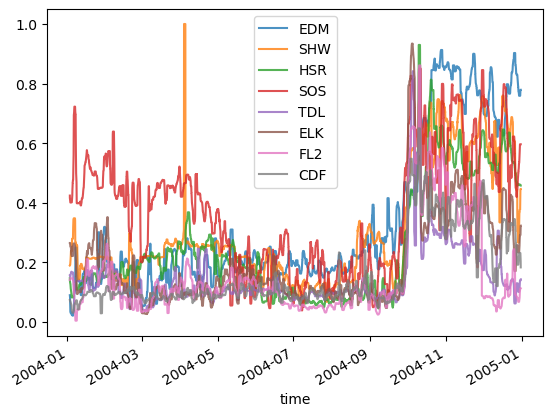

In [92]:
df_dsar_median.plot(alpha=0.8)

<AxesSubplot:xlabel='time'>

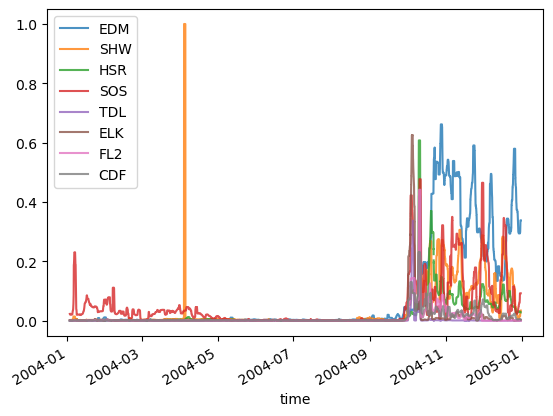

In [53]:
df_zscdsar_median.plot(alpha=0.8)